In [1]:
%matplotlib inline

# Import dependencies
import h5py
import numpy as np
from matplotlib import pyplot as plt
import fastmri
from fastmri.data import transforms as T
from fastmri.data.transforms import MaskFunc
import numpy as np
import torch
import sys
from typing import Dict, NamedTuple, Optional, Sequence, Tuple, Union
from fastmri.data.subsample import RandomMaskFunc
from fastmri.data.subsample import create_mask_for_mask_type
import os

In [2]:
# sys.path.append('/home/ubuntu/dbertic-project/fastMRI/fastmri_examples/adaptive_varnet')
sys.path.append('/home/ubuntu/dbertic-project/fastMRI')

In [3]:
def apply_mask(
    data: torch.Tensor,
    mask_func: MaskFunc,
    offset: Optional[int] = None,
    seed: Optional[Union[int, Tuple[int, ...]]] = None,
    padding: Optional[Sequence[int]] = None,
) -> Tuple[torch.Tensor, torch.Tensor, int]:
    """
    Subsample given k-space by multiplying with a mask.

    Args:
        data: The input k-space data. This should have at least 3 dimensions,
            where dimensions -3 and -2 are the spatial dimensions, and the
            final dimension has size 2 (for complex values).
        mask_func: A function that takes a shape (tuple of ints) and a random
            number seed and returns a mask.
        seed: Seed for the random number generator.
        padding: Padding value to apply for mask.

    Returns:
        tuple containing:
            masked data: Subsampled k-space data.
            mask: The generated mask.
            num_low_frequencies: The number of low-resolution frequency samples
                in the mask.
    """
    shape = (1,) * len(data.shape[:-3]) + tuple(data.shape[-3:])
    mask, num_low_frequencies = mask_func(shape, offset, seed)
    if padding is not None:
        mask[..., : padding[0], :] = 0
        mask[..., padding[1] :, :] = 0  # padding value inclusive on right of zeros

    masked_data = data * mask + 0.0  # the + 0.0 removes the sign of the zeros

    return masked_data, mask, num_low_frequencies

In [4]:
def to_tensor(data: np.ndarray) -> torch.Tensor:
    """
    Convert numpy array to PyTorch tensor.

    For complex arrays, the real and imaginary parts are stacked along the last
    dimension.

    Args:
        data: Input numpy array.

    Returns:
        PyTorch version of data.
    """
    if np.iscomplexobj(data):
        data = np.stack((data.real, data.imag), axis=-1)

    return torch.from_numpy(data)

In [5]:
# Define paths to image
original_image_path = "/hdd/dataset/multicoil_train/file_brain_AXT2_202_2020299.h5"
image_base_dir = "."
image_name = "file_brain_AXT2_202_2020299.h5"

In [6]:
hf = h5py.File(original_image_path)

In [7]:
print('Keys:', list(hf.keys()))
print('Attrs:', dict(hf.attrs))

Keys: ['ismrmrd_header', 'kspace', 'reconstruction_rss']
Attrs: {'acquisition': 'AXT2', 'max': 0.0010838669125264667, 'norm': 0.2034266024196255, 'patient_id': '70ee48ddab49a1e6ca50741c80f3afdee2658b59bf97313778c08a7333230ba4'}


In [8]:
volume_kspace = hf['kspace'][()]
print(volume_kspace.dtype)
print(volume_kspace.shape)

complex64
(16, 20, 640, 320)


In [9]:
# seed = 42
# mask_type = "equispaced" # for brain
# center_fractions = [0.08, 0.04]
# accelerations = [4, 8]

# mask = create_mask_for_mask_type(mask_type, center_fractions, accelerations)

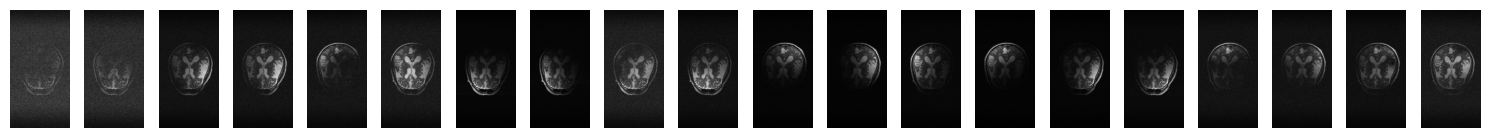

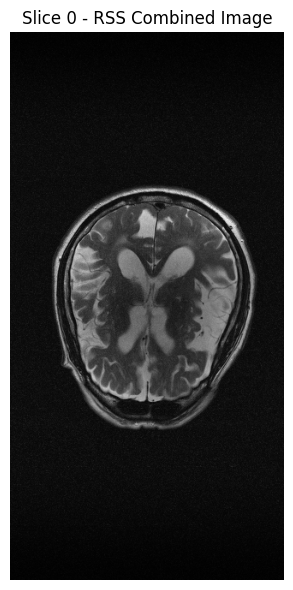

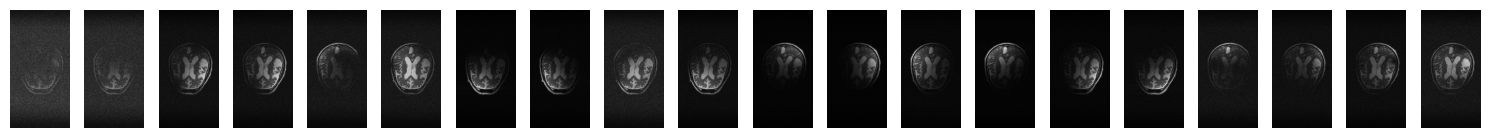

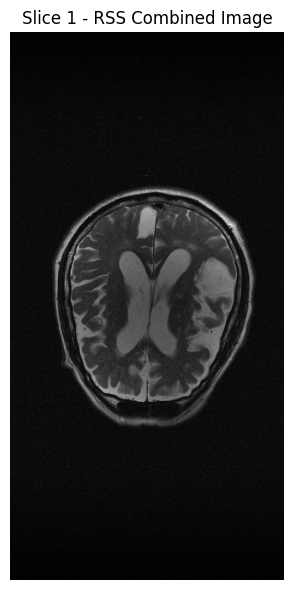

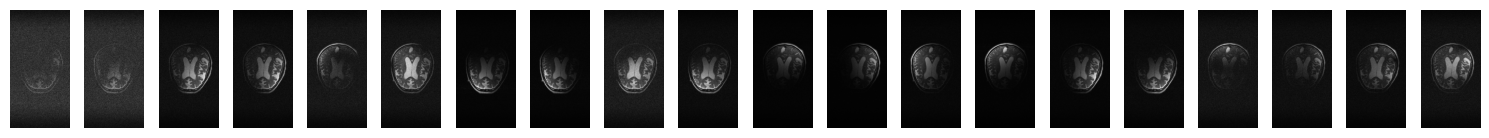

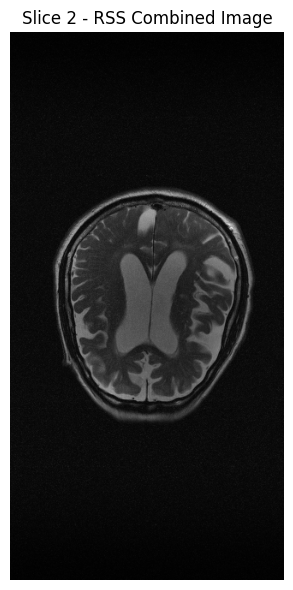

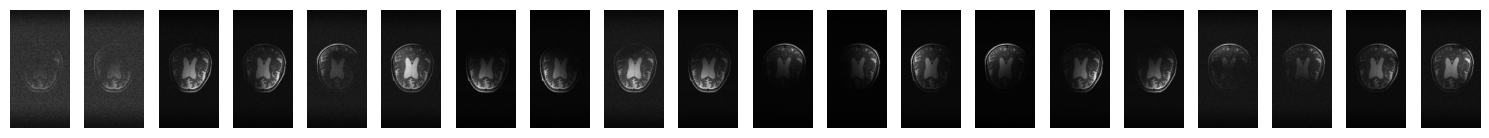

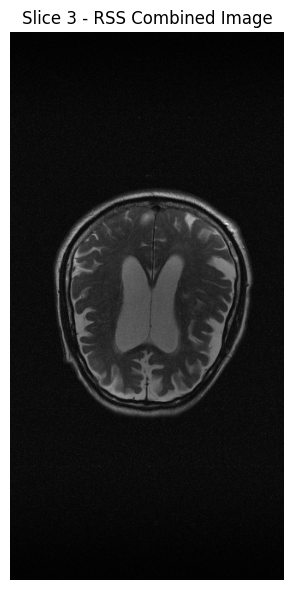

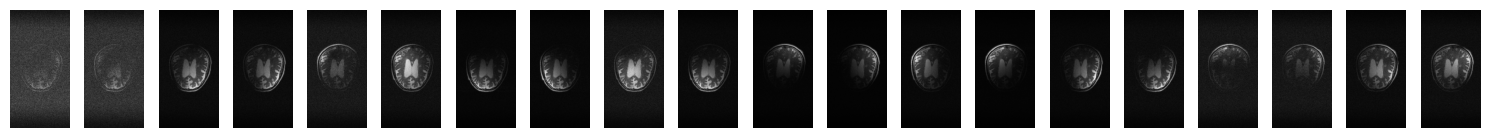

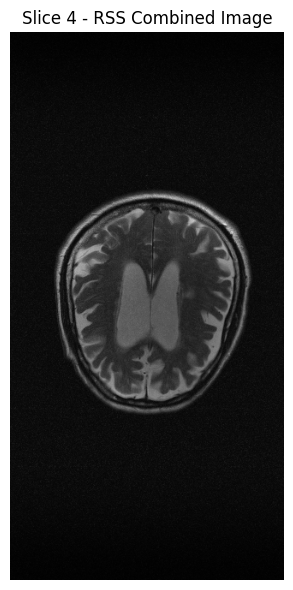

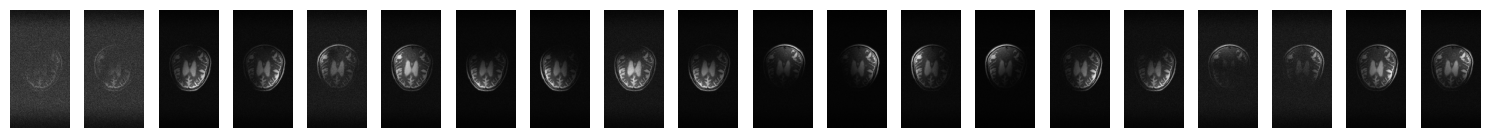

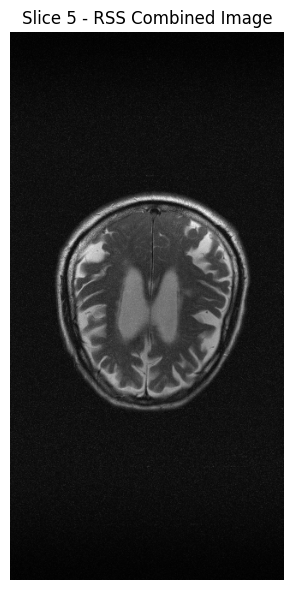

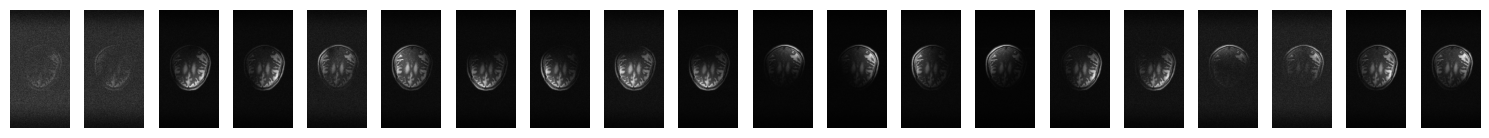

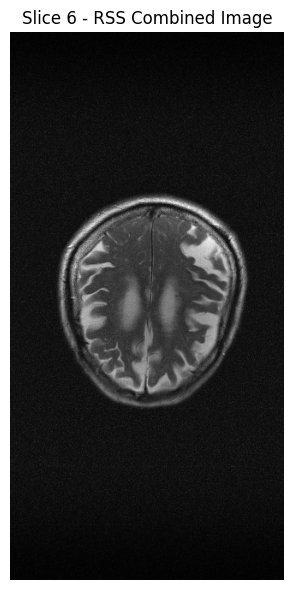

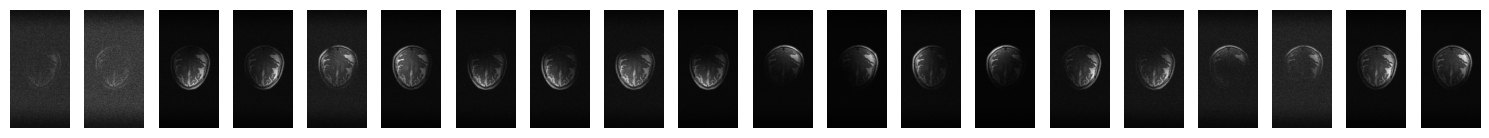

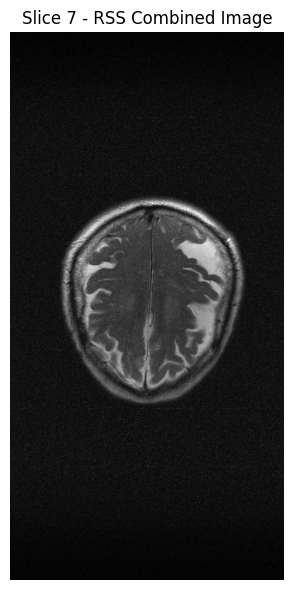

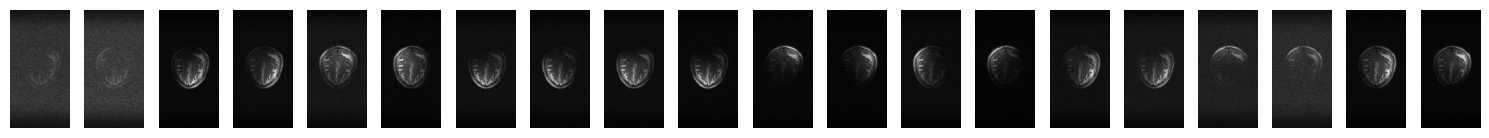

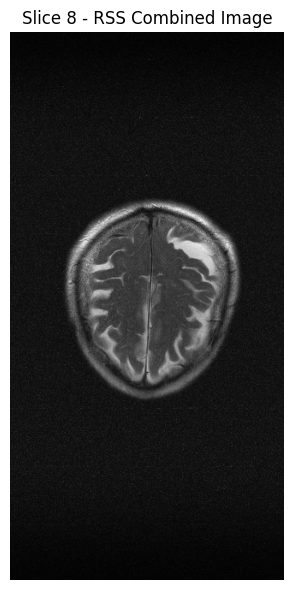

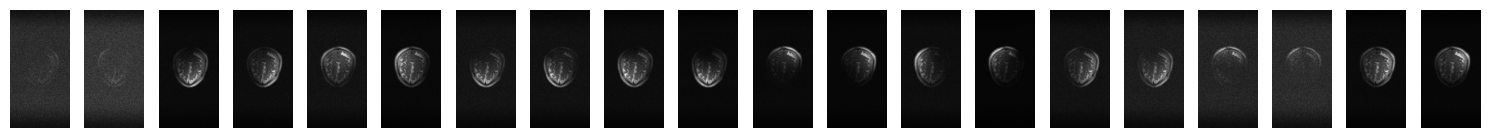

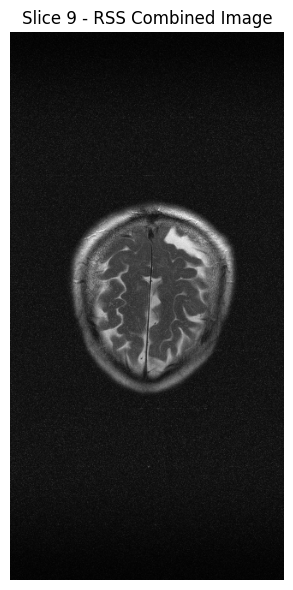

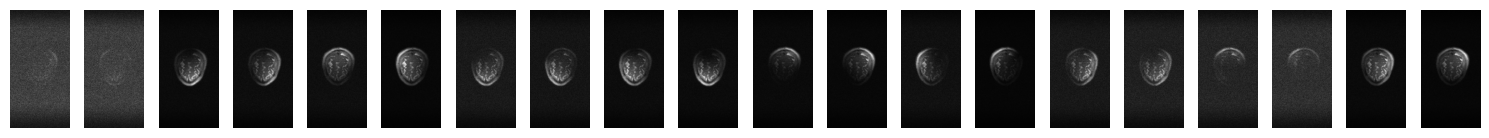

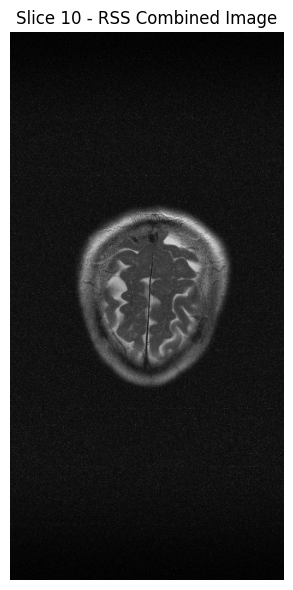

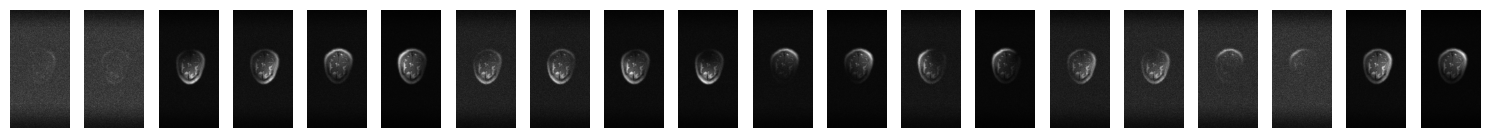

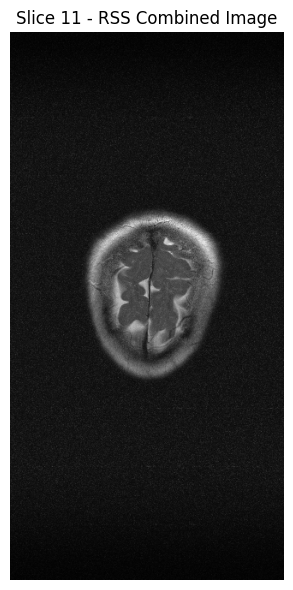

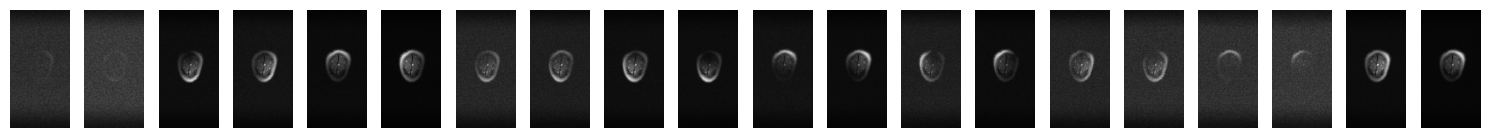

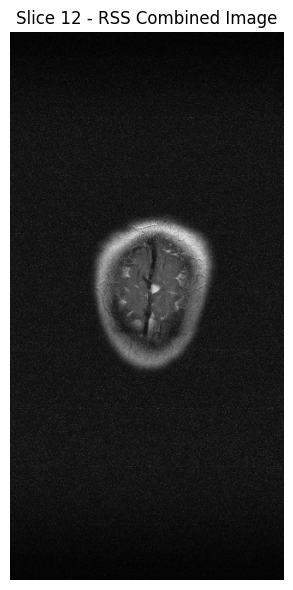

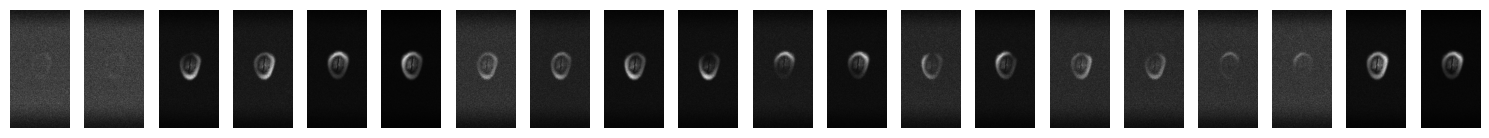

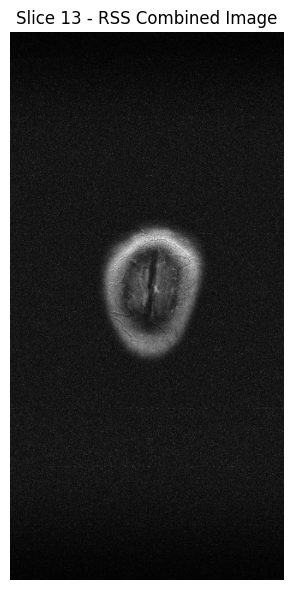

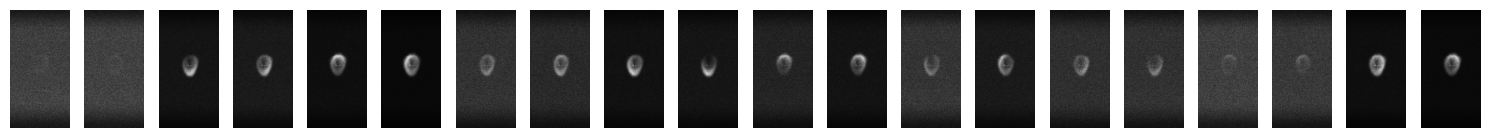

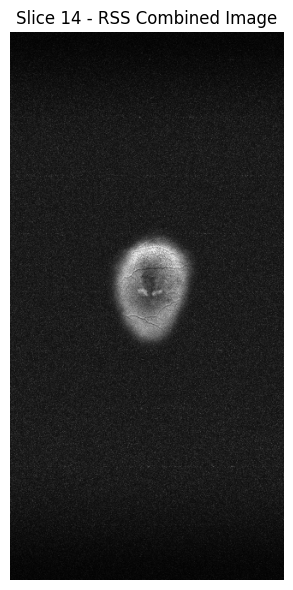

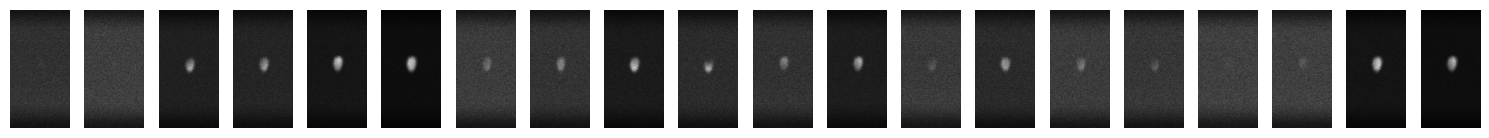

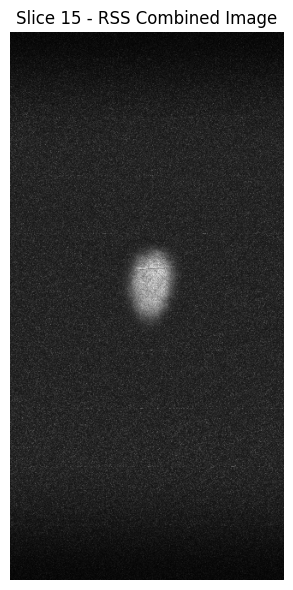

In [10]:
# Assuming volume_kspace is a 4D numpy array: (num_slices, num_coils, height, width)
for slice_idx, slice_data in enumerate(volume_kspace):
    num_coils = slice_data.shape[0]
    
    # Plot each coil's image for the current slice
    fig, axs = plt.subplots(1, num_coils, figsize=(15, 5))
    coil_images_abs = []
    
    for coil_idx, coil_data in enumerate(slice_data):
        ax = axs[coil_idx]
        # Assuming coil_data is numpy array and need to be converted to tensor
        slice_kspace2 = to_tensor(coil_data).unsqueeze(0)  # Add batch dimension for compatibility
        slice_image = fastmri.ifft2c(slice_kspace2)       # Apply Inverse Fourier Transform to get the complex image
        slice_image_abs = fastmri.complex_abs(slice_image) # Compute absolute value to get a real image
        coil_images_abs.append(slice_image_abs.squeeze(0)) # Remove batch dimension and collect for RSS

        # Plot individual coil image
        ax.imshow(slice_image_abs.squeeze().numpy(), cmap='gray')  # Squeeze to remove batch and channel dimensions
        ax.axis('off')
        ax.set_xlabel(f'Coil {coil_idx}')

    plt.tight_layout()
    plt.show()

    # Now, combine coil images using RSS and plot the combined image separately
    rss_image = fastmri.rss(torch.stack(coil_images_abs), dim=0).numpy()  # Combine along coil dimension
    plt.figure(figsize=(6, 6))
    plt.imshow(rss_image, cmap='gray')
    plt.title(f'Slice {slice_idx} - RSS Combined Image')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [11]:
output_file = "/home/ubuntu/dbertic-project/test/image.h5"
os.makedirs(os.path.dirname(output_file), exist_ok=True)

# Assuming volume_kspace is a 4D numpy array: (num_slices, num_coils, height, width)
# Pre-determine the number of slices and image dimensions to pre-allocate the array
num_slices = len(volume_kspace)
image_shape = None  # Initialize the image shape variable

# Use the first slice to determine the image dimensions
first_slice_data = volume_kspace[0]
first_slice_kspace2 = to_tensor(first_slice_data[0]).unsqueeze(0)  # Use the first coil for shape
first_slice_image = fastmri.ifft2c(first_slice_kspace2)
first_slice_image_abs = fastmri.complex_abs(first_slice_image).squeeze(0)
image_shape = first_slice_image_abs.shape

# Create an array to hold all images
all_images = np.zeros((num_slices,) + image_shape)

# Process each slice and populate the all_images array
for slice_idx, slice_data in enumerate(volume_kspace):
    num_coils = slice_data.shape[0]
    coil_images_abs = []

    for coil_idx, coil_data in enumerate(slice_data):
        slice_kspace2 = to_tensor(coil_data).unsqueeze(0)
        slice_image = fastmri.ifft2c(slice_kspace2)
        slice_image_abs = fastmri.complex_abs(slice_image).squeeze(0)
        coil_images_abs.append(slice_image_abs)

    rss_image = fastmri.rss(torch.stack(coil_images_abs), dim=0).numpy()
    all_images[slice_idx] = rss_image

# Save the combined images array under the 'images' key in the HDF5 file
with h5py.File(output_file, 'w') as h5_file:
    h5_file.create_dataset('images', data=all_images)
    print(f"Saved all combined images under 'images' key in {output_file}")

Saved all combined images under 'images' key in /home/ubuntu/dbertic-project/test/image.h5


In [13]:
hf = h5py.File(output_file)

print('Keys:', list(hf.keys()))
print('Attrs:', dict(hf.attrs))

Keys: ['images']
Attrs: {}


In [14]:
images = hf['images'][()]
print(images.dtype)
print(images.shape)

float64
(16, 640, 320)
